# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2024/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October 1st, 2024 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

# Part 1: Exploring the friendship paradox. 

This first part draws on the friendship paradox exercise from Week 3. You should provide solutions to the following exercises from **Part 3** of that week.

* *The friendship paradox in BA networks*
* *The friendship paradox more generally*
* *The friendship paradox and the configuration model*
* *Growth without preferential attachment*


We first create our own Barabasi-Albert model as explained in the beginning of Week 3 notebook. Friendship Paradox is a phenomenon that explains that on average, individual's friends have more friends than that individual [1]. 

In [2]:
import numpy as np
import networkx as nx
import random


In [30]:
# The Friendship Paradox in BA networks

# Initialize the Barabási-Albert network 
n_nodes = 5000
m_edges = 3  # Increasing the number of edges attached from each new node
random.seed(123)

# Start with a small connected network (m_0 nodes)
m_0 = 5 
ba = nx.Graph()
for i in range(m_0):
    for j in range(i + 1, m_0):
        ba.add_edge(i, j)

# Preferential attachment
for new_node in range(m_0, n_nodes):
    degrees = np.array([ba.degree(n) for n in ba.nodes])
    degree_sum = np.sum(degrees)

    # Compute the probability of connecting to each existing node
    probabilities = degrees / degree_sum

    # Choose m existing nodes to connect to based on the probabilities
    targets = np.random.choice(ba.nodes, size=m_edges, replace=False, p=probabilities)

    # Add edges between the new node and the chosen targets
    for target in targets:
        ba.add_edge(new_node, target)

# Function to test the friendship paradox for a random node
def test_friendship_paradox(G):
    # Choose a random node
    node = random.choice(list(G.nodes()))
    node_degree = G.degree[node]
    # Get neighbors of the node and calculate their average degree
    neighbors = list(G.neighbors(node))
    if neighbors:
        neighbors_degrees = [G.degree[neighbor] for neighbor in neighbors]
        avg_neighbors_degree = np.mean(neighbors_degrees)
        # Compare the if it is true that the neighbors have more "friends" than the random node
        return avg_neighbors_degree > node_degree
    # If node has no neighbors
    return False 

# Run the experiment 1000 times
num_trials = 1000
paradox_true_count = sum(test_friendship_paradox(ba) for _ in range(num_trials))

# Calculate the fraction of times the paradox is true
fraction_paradox_true = paradox_true_count / num_trials

# Part A result
print(f"Friendship paradox is true {fraction_paradox_true*100}% of the time")

Friendship paradox is true 90.5% of the time


> B. The friendship paradox more generally
> * What if the power law is flatter, e.g. $p(k) \sim k^{-\gamma}$ with $\gamma = 2$? Will the fraction of times the paradox is true be higher or lower? 
>  - First answer this question by simply reasoning. Think about what it would mean in terms of hubs that the power law is flatter? **In social networks we would find that the number of connections a node has doesn't follow a random pattern but a power law. Thus, there will be few nodes with a high number of connections known as hubs, and most of the nodes will have few connections. When the power law is flatter, we refer to a "extreme" case when the largest hub has even more connections than they would do in a steeper power law distribution.
In this context, we would see that in a network with power flatter distribution almost every node is connected to the largest hub, thus, the degree of this node will be greater than the average degree of the nodes in the network as a whole. Applying this to friendship, on average our friends have more friends than we do.**

>  - Now simulate a new network with the slope mentioned above. You can generate networks with power-law degree distributions using the [configuation model](https://en.wikipedia.org/wiki/Configuration_model). The `networkx` funtion is here [`nx.configuration_model`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html). I suggest you make the network pretty big ... let's say 5000 nodes or more.
>     * Hint 0: In the `networkx` function mentioned above, you need a degree sequence. This can be created using the so-called transformation method. If we can generate a random real number $r$ uniformly distributed in the range $0 \leq r < 1$, then $x = x_{\textrm{min}}(1 – r)^{-1/\alpha - 1}$ is a random power-law-distributed real number in the range $x_{\textrm{min}} \leq x < \infty$ with exponent $\alpha$. Note that there has to be a lower limit $x_\textrm{min}$ on the range; the power-law distribution diverges as $x\rightarrow 0$. See [this paper](https://www.cs.cornell.edu/courses/cs6241/2019sp/readings/Newman-2005-distributions.pdf) for more details.
>     * Hint 1: The sequence generated using the method mentioned above consists of real numbers, we need integers, so it needs to be rounded as well.
>     * Hint 2: Also, due to some details of how the configuation works (see the [wiki page](https://en.wikipedia.org/wiki/Configuration_model) for details), the sequence cannot have a sum which is an odd number, so if your sequence turns out odd, just choose an element and add 1 to its degree, that way the sum will be an even number.
> - Did you reason correctly above? For what fraction of the time is the friendship paradox true for your network with a new slope? **In this case, we see that the friendship paradox is true for almost 100% of the times.**

In [7]:
def configuration(alfa):
    x_min = 1
    r = np.random.uniform(size = 5000)
    x = (x_min*(1-r)**(-1/alfa -1)).astype(int)
    if np.sum(x)%2 != 0: 
        x = np.append(x, 1)

    configuration = nx.configuration_model(x)
    return configuration

def friendship_paradox_rate(configuration, n_nodes):

    nodes = np.random.choice(list(configuration.nodes), size = n_nodes)
    degrees_nodes = [configuration.degree[node] for node in nodes]
    degree_friend = []
    for node in nodes:
        friend_list = []
        for neigh in list(configuration.neighbors(node)):
            friend_list += [configuration.degree[neigh]]
        degree_friend += [np.average(friend_list)]
    true = (sum(np.array(degree_friend)> np.array(degrees_nodes)))
    return true 

flatter_configuration = configuration(2)
rate = friendship_paradox_rate(flatter_configuration, 1000)
print(f"Friendship paradox was true {rate} times, so {rate/1000*100}% of the time")

Friendship paradox was true 1000 times, so 100.0% of the time


> - Now generate a network for the configuration model that has *the same slope and number of nodes as **F-BA** in A above*; let's call this new network **F-CM** (for *friendship configuration model*). 
>    - What fraction of the time is the friendship paradox is true for the **F-CM** network? **Now the friendship paradox is true for approximately 90% of the times, while for an exponent degree of 2 it was almost 100% of the times.**
>    - Assuming that **F-BA** and **F-CM** have the same degree sequence can now *think* about if **F-BA** and **F-CM** are different with respect to the friendship paradox. Specifically, please explain your thoughts on the following topics
>       * Are there factors beyond the degree-distribution that could impact how frequently the friendship paradox is true? I might consider how network properties like assortativity, clustering, community-structure, etc potentially could impact things (it's OK to search online and add references to your answer). **Assortativity measures the tendency of nodes to connect to other nodes with similar properties, i.e., degree. Thus, the higher the assortativity means high degree nodes tend to connect to other high degree nodes. BA networks tend to have disassortativity, thus, low-degree nodes tend to connect to high degree nodes. CM have neutral assortativity, leading to less pronounced friendship paradox.**

>  * How would you test more rigorously if the friendship-paradox is actually true equally often in **F-BA** and **F-CM**? (E.g. how would you run a statistical test to investigate ... or how would you put error-bars on your plots?) **We can use a chi-square test for proportions of nodes for which the friendship paradox is true. In addition, friendship paradox could be quantified in terms of the difference between the characteristics of a node and the average of the same characteristics for the node's neighbors.** 

As we know from the book: "The Barabasi model predicts 
a power law exponent of $3$ while the degree exponent of real networks varies between $2$ and $5$". A power-law exponent of around $3$ means that it has a steep power-law distribution, rather than a flatter one. This is important because it causes that number of high-degree hubs is smaller and they are less dominant in the network than in if the exponent was $\gamma = 2$. As it can be seen in the following figure, the power law exponent is 3.05, which is very close to the theoretical value.

Calculating best minimal value for power law fit
Estimated power-law exponent (gamma): 3.0517580293726514


<Axes: >

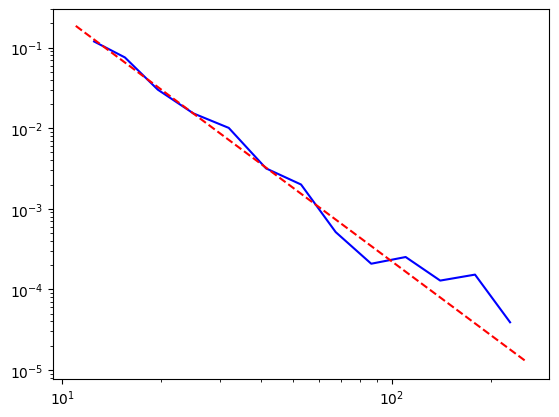

In [18]:
# needs powerlaw installed
import powerlaw

# Get degree distribution
degree_sequence = sorted([d for n, d in ba.degree()], reverse=True)

# Fit power law
fit = powerlaw.Fit(degree_sequence)

# Extract the estimated power-law exponent
gamma = fit.power_law.alpha
print(f"Estimated power-law exponent (gamma): {gamma}")

# Plot the degree distribution with the power-law fit
fit.plot_pdf(color='b')
fit.power_law.plot_pdf(color='r', linestyle='--')

In [29]:
# Extract the degree sequence from F-BA (G)
degree_sequence = [degree for node, degree in ba.degree()]

# Part 1: Create the F-CM (Friendship Configuration Model) using the degree sequence
G_FCM = nx.configuration_model(degree_sequence)

# Test friendship 
paradox_true_count = sum(test_friendship_paradox(G_FCM) for _ in range(num_trials))

# Calculate the fraction of times the paradox is true
fraction_paradox_true_fcm = paradox_true_count / num_trials

# Part A result
print(f"Friendship paradox for the FCM is true {fraction_paradox_true_fcm*100}% of the time")


Friendship paradox for the FCM is true 88.9% of the time


As we see, BA network has more pronounced friendship paradox.

 Growth without preferential attachment

> Finally, we'll build a network of same size and degree as in the exercise above, *using the growth mechanism without the preferential attachment*. Follow the steps below for success
> 
>  1. Grow a new network (the Sune-network) with the same parameters as the **F-BA** network in the exercise above, i.e. 5000 nodes, each new node connects to the existing network, but with one key difference: *have the incoming nodes connect to the existing nodes with* **equal probability**. This is the Sune-network.
>  2. Generate an ER network of same number of nodes and links as the Sune-network. 
> * What are the differences between the ER network and the Sune-network? Explain in your own words. **The Sune-Network grows similarly to BA network but without preferential attachment, it has random attachment. On the other hand, the ER network doesn't grow in a step-by-step fashion like the Sune one. 
Sune Network has longer tail, it includes nodes with higher degrees as it is based in a BA network. In ER networks, the degree distribution is concentrated in lower values. 
Regarding the assortativity of the networks, since the Sune-network has a degree of assortativity of close to 0, and the ER network has one of 0.025. The near-zero assortativity in the Sune-network indicates a more random connection pattern compared to the ER network. This can also be infered from the degree distribution plot, where we can see that the Sune network maintains a flatter distribution, while the ER network has a more varied distribution.**

>   * *Hints*: To get started, plot the two degree distribution in the same plot. Compare and contrast. Another revealing network property to study is the the number of connected components.

In [32]:
random.seed(123)
sune = nx.Graph()
sune.add_node(1)
for i in range(2,5000):
    sune.add_edge(i, np.random.choice(list(sune.nodes)))

In [33]:
er = nx.erdos_renyi_graph(5000, 1/5000)


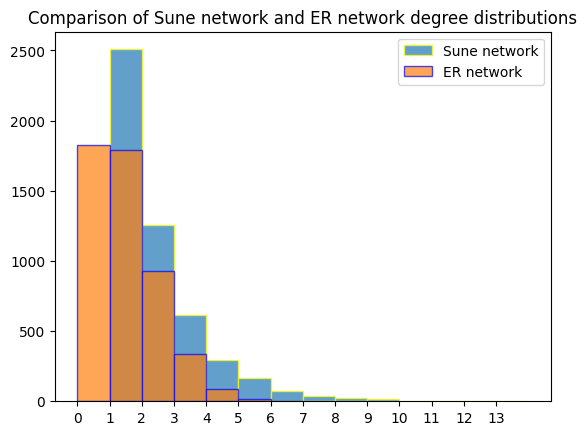

The Sune network is connected: True
The ER network is connected: False
Degree Assortativity for Sune: 0.0009416227314313435
Degree Assortativity for ER: 0.025289966025939584


In [34]:
sune_degrees = [x[1] for x in sune.degree]
max_sune = sorted(sune_degrees, reverse=True)[0]
min_sune = sorted(sune_degrees)[0]
bins_su = np.array(range(min_sune, max_sune+2))

er_degrees = [x[1] for x in er.degree]
max_er= sorted(er_degrees, reverse=True)[0]
min_er = sorted(er_degrees)[0]
bins_er = np.array(range(min_er, max_er+2))

plt.hist(sune_degrees, edgecolor='yellow', bins=bins_su, label = "Sune network", alpha = 0.7)
plt.hist(er_degrees, edgecolor='blue', bins=bins_er, label = "ER network", alpha = 0.7)
plt.title("Comparison of Sune network and ER network degree distributions")
plt.legend(loc='upper right')
plt.xticks(np.arange(min(sune_degrees)-1, max(sune_degrees)+1, 1.0))

plt.show()

print("The Sune network is connected:", nx.is_connected(sune))
print("The ER network is connected:", nx.is_connected(er))

import networkx as nx
assortativity = nx.degree_assortativity_coefficient(sune)
print(f"Degree Assortativity for Sune: {assortativity}")
assortativity = nx.degree_assortativity_coefficient(er)
print(f"Degree Assortativity for ER: {assortativity}")

# Part 2: Stats of the Country Music Network

This second part requires you to have built the network of Country Musicians as described in the exercises for Week 4. You should complete the following exercise from **Part 2**.

* *Simple network statistics and analysis*

And the following exercise from **Part 3**

* *Let's build a simple visualization of the network*

And that's it! You're all set.

# References

[1]  Feld, Scott L. (1991), "Why your friends have more friends than you do", American Journal of Sociology, 96 (6): 1464–1477, doi:10.1086/229693, JSTOR 2781907, S2CID 56043992.

[2] Cantwell, G. T., Kirkley, A., & Newman, M. E. (2021). The friendship paradox in real and model networks. Journal of Complex Networks, 9(2), cnab011.